# YOLOX-S-512 Detector - Inference

Run trained YOLOX-S-512 model.

In [1]:
import sys
sys.path.append("../code/src_object_detector/YOLOX")
sys.path.append("../code/src")
import cdc
from cdc.common.utils import *
from cdc.common.constants import *
from cdc.yolo.tools import *
from cdc.yolo.inference import *
from cdc.utils.imaging import *

/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import numpy as np
import pandas as pd
import glob
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=0.8)

import time, os, random, shutil
from tqdm.auto import tqdm
import torch
import cv2

from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, StratifiedGroupKFold

from globox.boundingbox import BoundingBox, BoxFormat
from globox.annotation import Annotation
from globox.annotationset import AnnotationSet

In [20]:
VERSION = "v3.1"
DATA_ROOT = "../data"
DATA_HOME = "../yolo_models/"
CONVERT_HOME = DATA_HOME + "data_coco_%s/"%VERSION
LABELS_HOME = os.path.join(DATA_HOME, "data_%s/labels/"%VERSION)
TRAIN_HOME = os.path.join(DATA_HOME, "data_%s/images/"%VERSION)
MODEL_YOLOX_HOME = "../code/src_object_detector/YOLOX/YOLOX_outputs"
TEST_FILE = os.path.join(DATA_ROOT, "test.csv")

ROOT =  "yolox_s"
IMG_SIZE = 512
DEVICE = "gpu"
TEST_CONFIDENCE = 0.001
PADDING_POLICY = "full"
NMS_THRESHOLD = 0.30
WBF_IOU = 0.25

SEEDS = [42]
FOLDS = 4
SURFACE_BINS = 3
SURFACE_RATIO_BINS = 4

NOISY = []
seed_everything_now(SEEDS[0])

In [4]:
cv_pd = pd.read_parquet(os.path.join(DATA_ROOT, "cv4_seed42_multilabel.parquet")) # BBx from train dataset
cv_pd_ = cv_pd[["NAME", "img_width", "img_height", "fold_s42", "bbx"]].explode('bbx').reset_index(drop=True)
print(cv_pd_.shape)
cv_pd_["trustii_id"] = cv_pd_.index
cv_pd_["x1"] = cv_pd_["bbx"].apply(lambda x: x[0]).astype(np.int32)
cv_pd_["y1"] = cv_pd_["bbx"].apply(lambda x: x[2]).astype(np.int32)
cv_pd_["x2"] = cv_pd_["bbx"].apply(lambda x: x[1]).astype(np.int32)
cv_pd_["y2"] = cv_pd_["bbx"].apply(lambda x: x[3]).astype(np.int32)
cv_pd_["class"] = cv_pd_["bbx"].apply(lambda x: x[4]).astype(np.int32)
cv_pd_["class"] = cv_pd_["class"].map(class_mapping)
cv_pd_ = cv_pd_[["trustii_id", "NAME", "x1", "y1", "x2", "y2", "class", "img_width", "img_height", "fold_s42"]]
# display(cv_pd_)
cv_pd = pd.merge(cv_pd, cv_pd_.groupby("NAME")[["trustii_id"]].agg(trustii_ids=("trustii_id", list)).reset_index(), on="NAME", how="left")
cv_pd.shape

(52586, 5)


(48263, 43)

In [5]:
# Trained model
MODELS = {
    "yolox_s_%s_512_seed_42"%VERSION: {
        "fold0":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold0"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
        "fold1":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold1"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
        "fold2":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold2"%(VERSION.replace(".", "") ,IMG_SIZE), IMG_SIZE),
        "fold3":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold3"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
    }
}

## Infer YOLOX folds and compute OOF

In [ ]:
for name, _ in MODELS.items():
    roi_predictions = []
    for fold in sorted(cv_pd["fold_s42"].unique()):
        valid_pd = cv_pd[cv_pd["fold_s42"] == fold]
        files = [os.path.join(TRAIN_HOME, f.split("/")[-1]) for f in valid_pd["filename"].values]
        path, imgsize = MODELS[name].get("fold%d"%fold) if MODELS[name].get("fold%d"%fold) is not None else (None, None)
        if path is not None:
            print("Path:", path)            
            if "yolox" in path:
                roi_predictions_ = predict_yolox(None, path + "/best_ckpt.pth", test_conf=TEST_CONFIDENCE, nmsthre=NMS_THRESHOLD, image_size=imgsize, files=files, device=DEVICE)
            roi_predictions_["fold_s42"] = fold
            roi_predictions.append(roi_predictions_)
    roi_predictions = pd.concat(roi_predictions, ignore_index=True)

In [7]:
roi_predictions_oof_pd = roi_predictions.copy()
roi_predictions_oof_pd["bbx_xtl"] = roi_predictions_oof_pd["bbx_xtl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_xbr"] = roi_predictions_oof_pd["bbx_xbr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_ybr"] = roi_predictions_oof_pd["bbx_ybr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_ytl"] = roi_predictions_oof_pd["bbx_ytl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["roi_width"] = roi_predictions_oof_pd["bbx_xbr"] - roi_predictions_oof_pd["bbx_xtl"]
roi_predictions_oof_pd["roi_height"] = roi_predictions_oof_pd["bbx_ybr"] - roi_predictions_oof_pd["bbx_ytl"]
roi_predictions_oof_pd["roi_surface"] = roi_predictions_oof_pd["roi_width"]*roi_predictions_oof_pd["roi_height"]
roi_predictions_oof_pd["roi_surface_ratio"] = roi_predictions_oof_pd["roi_surface"]*100./(roi_predictions_oof_pd["slide_width"]*roi_predictions_oof_pd["slide_height"])
roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr"]] = roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr", "slide_width", "slide_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")
roi_predictions_oof_pd = roi_predictions_oof_pd.rename(columns={'filename': 'NAME', 'slide_width': 'img_width', 'slide_height': 'img_height'})
roi_predictions_oof_pd["bb"] = roi_predictions_oof_pd[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6]), axis=1)
roi_predictions_oof_pd

/tmp/ipykernel_301382/3570674434.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr"]] = roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr", "slide_width", "slide_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")
/tmp/ipykernel_301382/3570674434.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_predictions_oof_pd["bb"] = roi_predictions_oof_pd[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5

,NAME,img_width,img_height,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,score,class,fold_s42,roi_width,roi_height,roi_surface,roi_surface_ratio,bb
0,00010aae-3.jpg,352,357,96,85,252,273,0.968306,0.0,0,156,188,29328,23.338426,"(96.0, 252.0, 85.0, 273.0, 0.0, 23.33842627960..."
1,00016779-d.jpg,352,357,90,110,258,247,0.970744,0.0,0,168,137,23016,18.315508,"(90.0, 258.0, 110.0, 247.0, 0.0, 18.3155080213..."
2,0003ab57-1.jpg,368,369,113,111,260,260,0.979511,0.0,0,147,149,21903,16.129816,"(113.0, 260.0, 111.0, 260.0, 0.0, 16.129816189..."
3,00105f3a-c.jpg,352,357,99,111,257,258,0.972207,0.0,0,158,147,23226,18.482620,"(99.0, 257.0, 111.0, 258.0, 0.0, 18.4826203208..."
4,0011abf6-6.jpg,608,608,185,182,431,429,0.973669,0.0,0,246,247,60762,16.437089,"(185.0, 431.0, 182.0, 429.0, 0.0, 16.437088815..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62643,ffd984f6-4.jpg,368,370,111,103,266,269,0.942056,0.0,3,155,166,25730,18.896886,"(111.0, 266.0, 103.0, 269.0, 0.0, 18.896886016..."
62644,ffd984f6-4.jpg,368,370,193,346,246,369,0.004978,0.0,3,53,23,1219,0.895270,"(193.0, 246.0, 346.0, 369.0, 0.0, 0.8952702702..."
62645,ffdb27ec-5.jpg,360,363,113,118,250,246,0.975121,0.0,3,137,128,17536,13.419039,"(113.0, 250.0, 118.0, 246.0, 0.0, 13.419038873..."
62646,ffeeca6e-6.jpg,360,363,96,93,266,271,0.977072,0.0,3,170,178,30260,23.155800,"(96.0, 266.0, 93.0, 271.0, 0.0, 23.15580042852..."


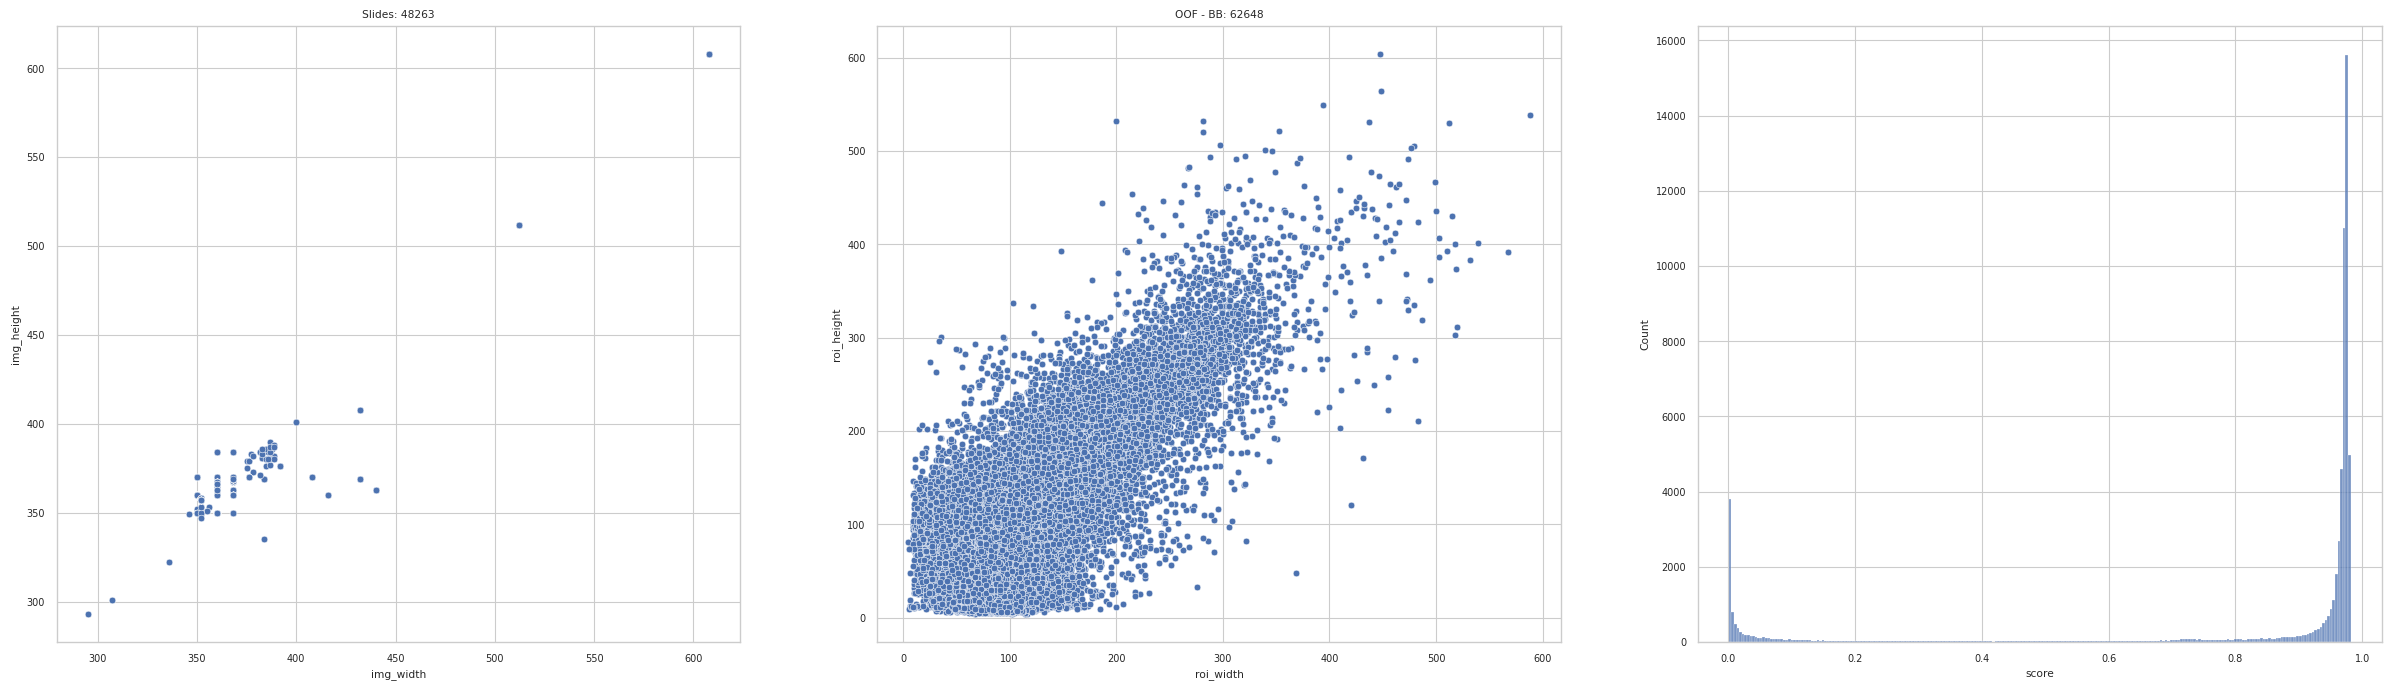

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(30,8))
d = sns.scatterplot(data=roi_predictions_oof_pd, x="img_width", y="img_height", ax=ax[0])
d = sns.scatterplot(data=roi_predictions_oof_pd, x="roi_width", y="roi_height", ax=ax[1])
d = sns.histplot(data=roi_predictions_oof_pd, x="score", ax=ax[2])
d = ax[0].set_title("Slides: %d" % roi_predictions_oof_pd["NAME"].nunique())
d = ax[1].set_title("OOF - BB: %d" % roi_predictions_oof_pd.shape[0])
plt.show()

In [9]:
oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), oof_roi_height_max=("roi_height", np.max)).reset_index()
oof_pd["oof_bbs"] = oof_pd["oof_bbx"].apply(lambda x: len(x))
oof_pd = pd.merge(oof_pd, cv_pd, on=["NAME", "img_width", "img_height", "fold_s42"], how="inner")
print("Too much predictions:", oof_pd[oof_pd["oof_bbs"] > oof_pd["bbs"]].shape)
print("Not enough predictions:", oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]].shape)
print("Equal predictions:", oof_pd[oof_pd["oof_bbs"] == oof_pd["bbs"]].shape)
not_enough_oof = oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]]["NAME"].unique()

# Padding
oof_pd["oof_bbx"] = oof_pd[["oof_bbx", "bbs", "img_width", "img_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)
oof_pd["oof_bbs"] = oof_pd["oof_bbx"].apply(lambda x: len(x))
oof_pd["bbs"] = oof_pd["bbx"].apply(lambda x: len(x))
oof_pd["bb_score_avg"] = oof_pd["oof_bbx"].apply(lambda x: compute_bbx_avg_score(x))
print("After padding")
print("Too much predictions:", oof_pd[oof_pd["oof_bbs"] > oof_pd["bbs"]].shape)
print("Not enough predictions:", oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]].shape)
print("Equal predictions:", oof_pd[oof_pd["oof_bbs"] == oof_pd["bbs"]].shape)

/tmp/ipykernel_301382/2855968291.py:1: FutureWarning: The provided callable <function mean at 0x7fe891367520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), oof_roi_height_max=("roi_height", np.max)).reset_index()
/tmp/ipykernel_301382/2855968291.py:1: FutureWarning: The provided callable <function max at 0x7fe891366c20> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), 

Too much predictions: (6895, 48)
Not enough predictions: (18, 48)
Equal predictions: (41350, 48)
After padding
Too much predictions: (0, 48)
Not enough predictions: (0, 48)
Equal predictions: (48263, 48)


In [ ]:
test_pd = pd.read_csv(TEST_FILE)
files = [os.path.join(TRAIN_HOME, f) for f in test_pd["NAME"].values]
for name, _ in MODELS.items():
    test_roi_predictions = []        
    for fold, info in MODELS[name].items():
        path, imgsize = info
        print("Path:", path)            
        if "yolox" in path:
            roi_predictions_ = predict_yolox(None, path + "/best_ckpt.pth", test_conf=TEST_CONFIDENCE, nmsthre=NMS_THRESHOLD, image_size=imgsize, files=files, device=DEVICE)               
        test_roi_predictions.append(roi_predictions_)
    test_roi_predictions = pd.concat(test_roi_predictions, ignore_index=True)

In [25]:
test_roi_predictions_pd = test_roi_predictions.copy()
test_roi_predictions_pd["roi_width"] = test_roi_predictions_pd["bbx_xbr"] - test_roi_predictions_pd["bbx_xtl"]
test_roi_predictions_pd["roi_height"] = test_roi_predictions_pd["bbx_ybr"] - test_roi_predictions_pd["bbx_ytl"]
test_roi_predictions_pd["roi_surface"] = test_roi_predictions_pd["roi_width"]*test_roi_predictions_pd["roi_height"]
test_roi_predictions_pd["roi_surface_ratio"] = test_roi_predictions_pd["roi_surface"]*100./(test_roi_predictions_pd["slide_width"]*test_roi_predictions_pd["slide_height"])
print(test_roi_predictions_pd.shape)
roi_predictions_wbf = run_wbf(test_roi_predictions_pd, iou_thr=WBF_IOU, skip_box_thr=0.0001)
roi_predictions_wbf["bbx_xtl"] = roi_predictions_wbf["bbx_xtl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_xbr"] = roi_predictions_wbf["bbx_xbr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_ybr"] = roi_predictions_wbf["bbx_ybr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_ytl"] = roi_predictions_wbf["bbx_ytl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["roi_width"] = roi_predictions_wbf["bbx_xbr"] - roi_predictions_wbf["bbx_xtl"]
roi_predictions_wbf["roi_height"] = roi_predictions_wbf["bbx_ybr"] - roi_predictions_wbf["bbx_ytl"]
roi_predictions_wbf["roi_surface"] = roi_predictions_wbf["roi_width"]*roi_predictions_wbf["roi_height"]
roi_predictions_wbf["roi_surface_ratio"] = roi_predictions_wbf["roi_surface"]*100./(roi_predictions_wbf["slide_width"]*roi_predictions_wbf["slide_height"])
roi_predictions_wbf["predict_bb"] = roi_predictions_wbf[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6]), axis=1)
print(roi_predictions_wbf.shape)

(142213, 13)


/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/tmp/ipykernel_301382/3877519107.py:

(29460, 14)


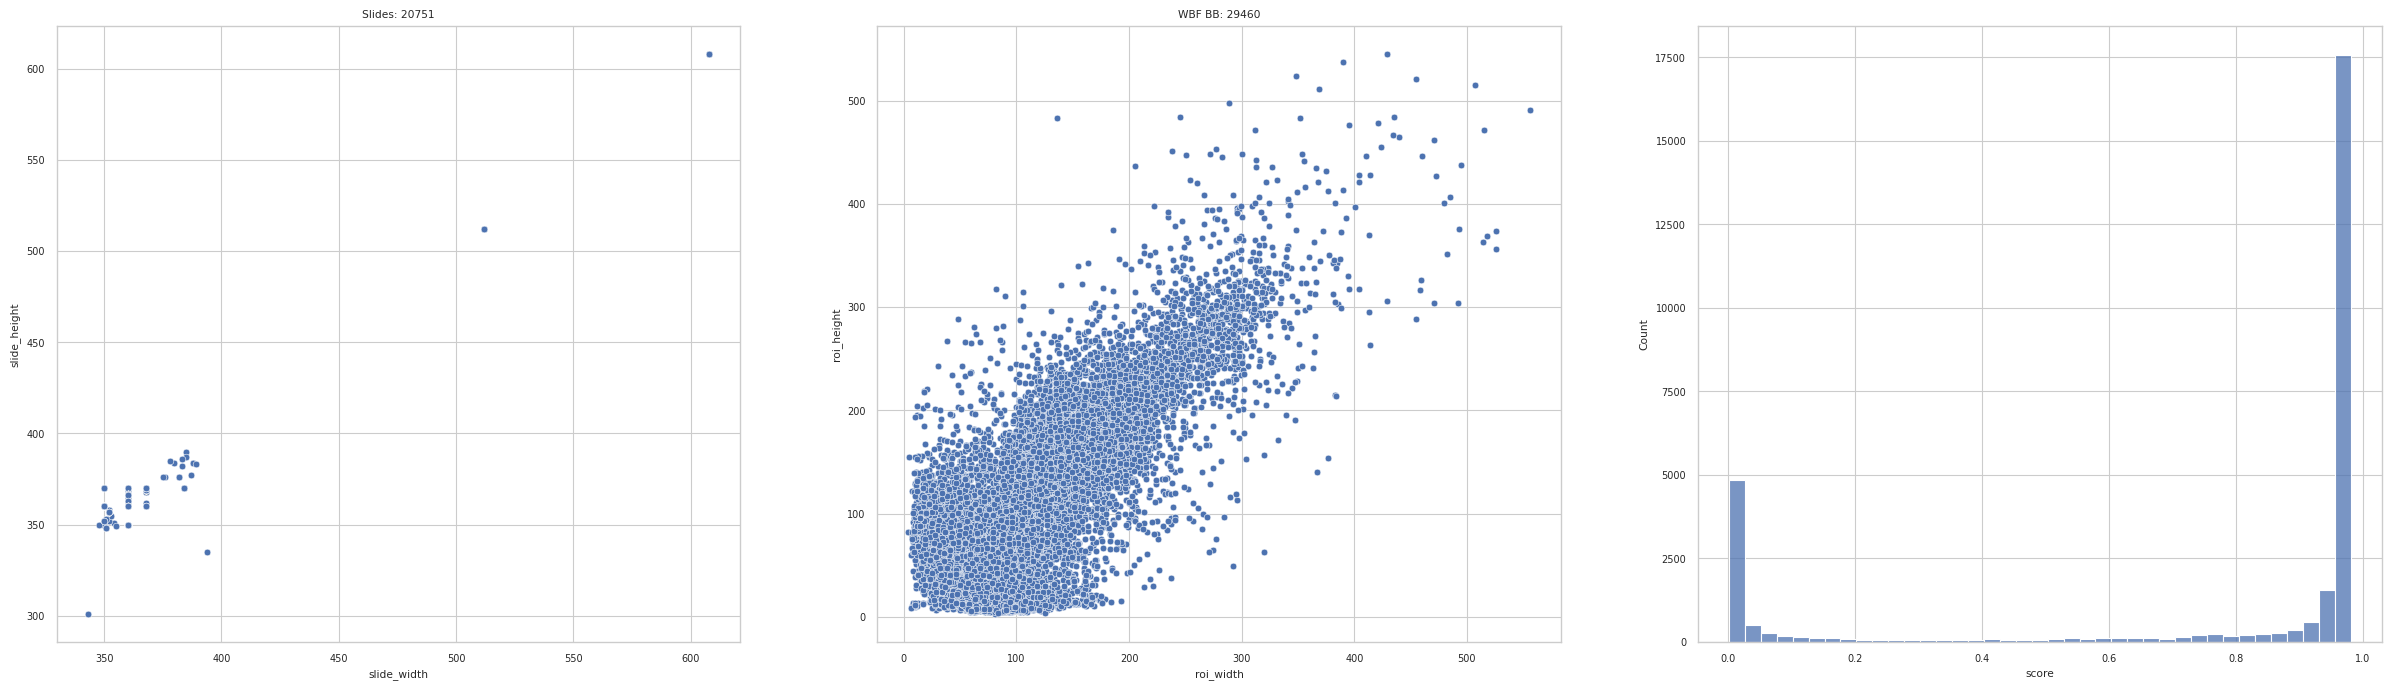

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(30,8))
d = sns.scatterplot(data=roi_predictions_wbf, x="slide_width", y="slide_height", ax=ax[0])
d = sns.scatterplot(data=roi_predictions_wbf, x="roi_width", y="roi_height", ax=ax[1])
d = sns.histplot(data=roi_predictions_wbf, x="score", ax=ax[2])
d = ax[0].set_title("Slides: %d" % roi_predictions_wbf["filename"].nunique())
d = ax[1].set_title("WBF BB: %d" % roi_predictions_wbf.shape[0])
plt.show()

In [27]:
print(test_pd.shape)
test_image_pd = test_pd.groupby("NAME")[["trustii_id"]].agg(trustii_ids=("trustii_id", list), trustii_bbs=("trustii_id", 'count')).reset_index()
a = test_image_pd.groupby("trustii_bbs")["NAME"].count().reset_index()
a["percent"] = a["NAME"]*100/a["NAME"].sum()
roi_image_predictions_wbf = roi_predictions_wbf.sort_values(["filename", "score", "roi_surface_ratio"], ascending=[True, False, False]).reset_index(drop=True)
roi_image_predictions_wbf = roi_image_predictions_wbf.groupby(["filename", "slide_width", "slide_height"])[["predict_bb"]].agg(list).reset_index().rename(columns={'filename':'NAME'})
roi_image_predictions_wbf["predict_bbs"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: len(x))
roi_image_predictions_wbf = pd.merge(roi_image_predictions_wbf, test_image_pd, on="NAME", how="inner")
print("Too much predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] > roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Not enough predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Equal predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] == roi_image_predictions_wbf["trustii_bbs"]].shape)
not_enough_predict = roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]]["NAME"].unique()
# Fit to expected number of BB
roi_image_predictions_wbf["predict_bb"] = roi_image_predictions_wbf[["predict_bb", "trustii_bbs", "slide_width", "slide_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)
roi_image_predictions_wbf["predict_bbs"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: len(x))
roi_image_predictions_wbf["predict_score_avg"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: compute_bbx_avg_score(x))
print("Too much predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] > roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Not enough predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Equal predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] == roi_image_predictions_wbf["trustii_bbs"]].shape)
roi_image_predictions_wbf.to_parquet(os.path.join(DATA_ROOT, "test_%s_%d_%s.parquet" % (ROOT, IMG_SIZE, VERSION)))

(22689, 2)
Too much predictions: (4497, 7)
Not enough predictions: (10, 7)
Equal predictions: (16244, 7)


/tmp/ipykernel_301382/2878871835.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_image_predictions_wbf["predict_bb"] = roi_image_predictions_wbf[["predict_bb", "trustii_bbs", "slide_width", "slide_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)


Too much predictions: (0, 8)
Not enough predictions: (0, 8)
Equal predictions: (20751, 8)


In [31]:
oof_pd_completed = pd.concat([oof_pd, roi_image_predictions_wbf.rename(columns={'predict_bb': 'oof_bbx', 'predict_bbs':'oof_bbs', 'predict_score_avg': 'bb_score_avg', 'slide_width':'img_width', 'slide_height':'img_height'})], ignore_index=True)
oof_pd_completed.to_parquet(os.path.join(DATA_ROOT, "cv4_seed42_multilabel_oof_%s_%d_%s.parquet" % (ROOT, IMG_SIZE, VERSION)))